# UNet2D-VisualizationPredictions

In [1]:
%pylab inline

import logging
import sys
from collections import namedtuple
from itertools import chain

# Código que utiliza las cajas para obtener valores objetivos del rendimiento de la red.
import emsa

import numpy as np
import scipy
from scipy import ndimage
from scipy import ndimage as ndi
from scipy.misc import imsave
from scipy.spatial import distance_matrix
from scipy.sparse.csgraph import connected_components
import matplotlib.pyplot as plt

import torch
from torch.autograd import Variable
from torch import optim

import unet
from unet.utils import BinCounter

logger = logging.getLogger(__name__)

# Tool to debug the code in python
import IPython
# IPython.embed()

plt.rcParams["figure.figsize"] = (12, 8)

Populating the interactive namespace from numpy and matplotlib


In [2]:
unet.config_logger("/dev/null")

In [3]:
# Function that permit us to detect/work with the centers and no with the projections of the dilation
def nonmaxima_suppression(img, return_mask=True):
    # smooth_img = img # ndi.gaussian_filter(img, 1)
    dilated = ndi.grey_dilation(img, (5,) * img.ndim)
    argmaxima = np.logical_and(img == dilated, img > 0.5)

    argwhere = np.argwhere(argmaxima)

    if not return_mask:
        return argwhere

    return argwhere, argmaxima

In [4]:
def inverse_argwhere(coords, shape, dtype):
    
    res = np.zeros(shape, dtype=dtype)
    intcoords = np.int_(np.round(coords))
    res[intcoords[:, 0], intcoords[:, 1], intcoords[:, 2]] = 1
    return res

In [5]:
def precision_and_recall(testing_coords, pred_coords, match_distance):
    w = scipy.spatial.distance_matrix(testing_coords, pred_coords)
    row_ind, col_ind = scipy.optimize.linear_sum_assignment(w)

    res = []
    for i in range(row_ind.shape[0]):
        if w[row_ind[i], col_ind[i]] <= match_distance:
            res.append(w[row_ind[i], col_ind[i]])

    precision = len(res) / len(pred_coords)
    recall = len(res) / len(testing_coords) 
    
    return precision, recall, len(res), len(pred_coords), len(testing_coords)

In [6]:
def reduce_metrics(results):
    
    tp = sum(i.tp for i in results)
    tp_fp = sum(i.tp_fp for i in results)
    tp_fn = sum(i.tp_fn for i in results)
    true_sums = np.array([i.true_sums for i in results])
    pred_sums = np.array([i.pred_sums for i in results])
    volumes = np.array([i.volumes for i in results])
    
    precision = tp / tp_fp
    recall = tp / tp_fn
    
    error = emsa.diff_vesicles_per_voxel(true_sums, pred_sums, volumes)
    
    return Metrics(precision, recall, tp, tp_fp, tp_fn,
                   error, true_sums, pred_sums, volumes)

In [7]:
logger.info("Creating the Network...")
num_classes = 2
unet_config = unet.UNetConfig(steps=2,
                              ndims=2,
                              num_classes=num_classes,
                              first_layer_channels=64,
                              num_input_channels=1,
                              two_sublayers=True)

unet_clsf = unet.UNetClassifier(unet_config).cuda() # .cuda() moves the network to GPU

2018-02-05 16:57:28,709 [__main__] Creating the Network...


In [8]:
unet_clsf.load_state_dict(torch.load('../notebooks/cvlabdata1/home/mas/UNet-2D-Task12-FinalResult/network_310000.pth'))

In [9]:
testing_xb = np.float32(unet.load_volume("/cvlabdata1/home/marquez/vesicles/striatum_testing/Bouton 4/img.tif")) / 255.0
# testing_xw = np.float32(unet.load_volume("/cvlabdata1/home/marquez/vesicles/hipp_testing/Bouton 1/img.tif")) / 255.0


In [10]:
pred_stack_best = np.array([unet.predict_in_blocks(unet_clsf, i, (100, 100), verbose=False)[1] for i in testing_xb])
# pred_stack_worst = np.array([unet.predict_in_blocks(unet_clsf, i, (100, 100), verbose=False)[1] for i in testing_xw])

In [11]:
pred_stack_best.shape

(318, 180, 176)

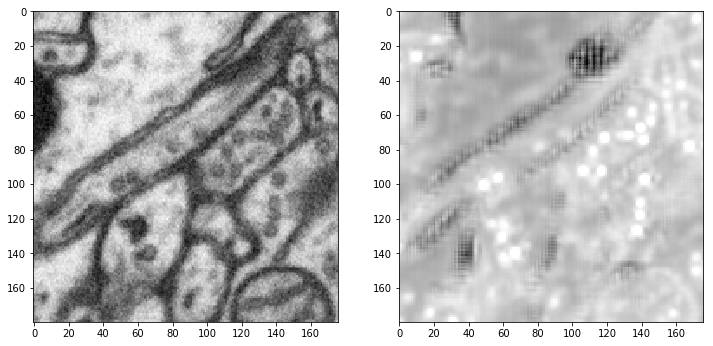

In [16]:
# Beter stack
plt.subplot(1, 2, 1)
i = 70
plt.imshow(testing_xb[i])
plt.subplot(1, 2, 2)
plt.imshow(pred_stack_best[i])

In [13]:
# Worst Stack
# plt.subplot(1, 2, 1)
# i = 30
# plt.imshow(testing_xw[i])
# plt.subplot(1, 2, 2)
# plt.imshow((pred_stack_worst[i]) + testing_xw[i])

In [14]:
# Best stack
testing_x = np.float32(unet.load_volume("/cvlabdata1/home/marquez/vesicles/striatum_testing/Bouton 4/img.tif")) / 255.0

testing_coords, radius = np.load("/cvlabdata1/home/marquez/vesicles/striatum_testing/Bouton 4/vesicles.npy", encoding = 'bytes') 
testing_coords = np.vstack(testing_coords)
radius = np.float_(radius)

mask = np.float32(unet.load_volume("/cvlabdata1/home/mas/vesicles/striatum_testing/Bouton 4/mask.tif"))

# Worst stack
# testing_x7 = np.float32(unet.load_volume("/cvlabdata1/home/marquez/vesicles/hipp_testing/Bouton 1/img.tif")) / 255.0
# logger.info("Computing 3D dilation in Testing dataset 7...")

# testing_coords7, radius7 = np.load("/cvlabdata1/home/marquez/vesicles/hipp_testing/Bouton 1/vesicles.npy", encoding = 'bytes') 
# testing_coords7 = np.vstack(testing_coords7)
# radius7 = np.float_(radius7)

# mask7 = np.float32(unet.load_volume("/cvlabdata1/home/mas/vesicles/hipp_testing/Bouton 1/mask.tif"))

In [17]:
# Precision&Recall best stack
# pred_coords, pred_y = nonmaxima_suppression(pred_stack_best * mask, True)

# testing_y = inverse_argwhere(testing_coords, testing_x.shape, dtype=np.float32)

# soft_testing_y = ndi.gaussian_filter(testing_y, 2)
# soft_pred_y = ndi.gaussian_filter(np.float32(pred_y), 2)

# vesicle_radius = 4
# true_sums, pred_sums, volumes = emsa.ersa(soft_testing_y, soft_pred_y, mask, 1000000, vesicle_radius)
# error = emsa.diff_vesicles_per_voxel(true_sums, pred_sums, volumes)

# precision, recall, tp, tp_fp, tp_fn = precision_and_recall(testing_coords, pred_coords,
#                                                            match_distance=vesicle_radius)

# results = []
# Metrics = namedtuple('Metrics', ['precision', 'recall', 'tp', 'tp_fp', 'tp_fn',
#                                  'error', 'true_sums', 'pred_sums', 'volumes'])
# results.append(Metrics(precision, recall, tp, tp_fp, tp_fn,
#                        error, true_sums, pred_sums, volumes))

# total = reduce_metrics(results)
# logger.info("\tPrecision: {:.3f}. "
#             "Recall: {:.3f}. "
#             "Error: {:.3e} elements/voxel.".format(total.precision, total.recall, total.error))

In [ ]:
# Precision&Recall WORST STACK
# pred_coords, pred_y = nonmaxima_suppression(pred_stack_worst * mask7, True)

# testing_y = inverse_argwhere(testing_coords7, testing_x7.shape, dtype=np.float32)

# soft_testing_y = ndi.gaussian_filter(testing_y, 2)
# soft_pred_y = ndi.gaussian_filter(np.float32(pred_y), 2)

# vesicle_radius = 4
# true_sums, pred_sums, volumes = emsa.ersa(soft_testing_y, soft_pred_y, mask7, 1000000, vesicle_radius)
# error = emsa.diff_vesicles_per_voxel(true_sums, pred_sums, volumes)

# precision, recall, tp, tp_fp, tp_fn = precision_and_recall(testing_coords7, pred_coords,
#                                                            match_distance=vesicle_radius)

# results = []
# Metrics = namedtuple('Metrics', ['precision', 'recall', 'tp', 'tp_fp', 'tp_fn',
#                                  'error', 'true_sums', 'pred_sums', 'volumes'])
# results.append(Metrics(precision, recall, tp, tp_fp, tp_fn,
#                        error, true_sums, pred_sums, volumes))

# total = reduce_metrics(results)
# logger.info("\tPrecision: {:.3f}. "
#         "Recall: {:.3f}. "
#         "Error: {:.3e} elements/voxel.".format(total.precision, total.recall, total.error))

In [ ]:
# Ampliation of a zone after the non-maxima supression

# argwhere, argmaxima = nonmaxima_suppression(pred_stack8, True)
# distances = distance_matrix(argwhere, argwhere)
# print((distances<3).sum(), distances.shape[0])
# plt.imshow(argmaxima[83])

In [ ]:
# Save the results as a 'tiff'

# import tifffile
# tifffile.imsave("/cvlabdata1/home/mas/maxima.tif", np.float32(argmaxima))
# tifffile.imsave("/cvlabdata1/home/mas/pred.tif", pred_stack_worst*mask7)

In [ ]:
# Zoom into specific slide zone

# coords, argmaxima = nonmaxima_suppression(pred_stack7 * mask7, True)
# img = pred_stack7[75:88, 150:190 ,70:130]
# coords, argmaxima = nonmaxima_suppression(img, True)
# dilated = ndi.grey_dilation(img, (9,) * img.ndim)
# plt.imshow(argmaxima[6])